In [1]:
from matplotlib import pyplot as plt
import numpy as np
import letalker as lt

# `letalker.function_generators`

Function and noise generators are the foundation to numerical voice simulation to generate time samples of various input signals and parameters. Function generators allow you to construct time-varying model parameters while noise generators are essential to add turbulent or ambient noise to the voice signals.

All classes in this module are a subclass of the `abc.SampleGenerator` abstract class. There are 3 abstract subclasses to further categorize:

| class                           | description                                                                                                                                                                       |
|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `abc.FunctionGenerator`         | abstract class to define `__call__()`, `derivative()`, and `antiderivative()` generation methods                                                                                  |
| `abc.AnalyticFunctionGenerator` | subclass of `FunctionGenerator`, requiring `fo` argument to construct. and accepts `analytic` `bool` keyword argument to the generation methods to generate the analytic signals. |
| `abc.NoiseGenerator`            | abstract class for random noise generation via `__call__()`                                                                                                                       |

- Concrete classes of `abc.FunctionGenerator`:

| class                 | description                                                       |
|-----------------------|-------------------------------------------------------------------|
| `Constant`            | constant (for adding tapering effects; otherwise use `float`)     |
| `StepGenerator`       | piece-wise constants, stepping from one constant value to another |
| `LineGenerator`       | linear function generator                                         |
| `Interpolator`        | B-Spline interpolator                                             |
| `ClampedInterpolator` | B-Spline interpolator, extrapolating by holding its endpoints     |

- Concrete classes of `abc.AnalyticFunctionGenerator`:

| class                    | description                                                                    |
|--------------------------|--------------------------------------------------------------------------------|
| `PeriodicInterpolator`   | B-Spline interpolator, extrapolating by endlessly repeating the control points |
| `SineGenerator`          | Pure sinusoid generator                                                        |
| `FlutterGenerator`       | Sum of sinusoids to generate quasi-random drift                                |
| `ModulatedSineGenerator` | Sinusoid generator with amplitude and frequency modulation                     |
| `RosenbergGenerator`     | Glottal flow pulse train generator per (Rosenberg, 1971)                       |

- Concrete classes of `abc.NoiseGenerator`:

| class                   | description             |
|-------------------------|-------------------------|
| `WhiteNoiseGenerator`   | White noise generator   |
| `ColoredNoiseGenerator` | Colored noise generator |


## Common attributes of `abc.SampleGenerator` subclasses


```python
# common properties
function_generator.shape # shape of an individual time sample
function_generator.ndim # number of dimensions of an individual time sample
function_generator.fs # sampling rate in samples/second

# common method
t = function_generator.ts(nb_samples=1000, n0=-500)
# generates time vector `t` which is 1000 samples long, starting from the index -500.
# With the default fs = 44100: t[0] = -500/44100, t[1] = -499/44100, ...
# If `function_generator.ndim>1`, `t` is an `(ndim+1)`-dimensional array with the 0-th
# dimension as the time dimension.
```


In [2]:
n = int(lt.fs)  # 1 second demos
t = lt.ts(lt.fs) # time vector

## `Constant`

`Constant` class simply holds the specified value all the time, unless the `transition_time` is set.


(0.0, 1.0)

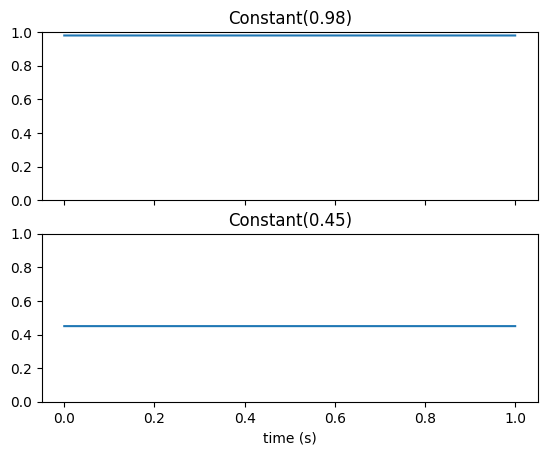

In [3]:
gen0 = lt.Constant(0.98)
gen1 = lt.Constant(0.45)

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(t, gen0(n, force_time_axis='tile_data'))
axes[0].set_title("Constant(0.98)")
axes[1].plot(t, gen1(n, force_time_axis='tile_data'))
axes[1].set_title("Constant(0.45)")
axes[1].set_xlabel("time (s)")
axes[1].set_ylim((0, 1))

NOTE: For faster simulation, a `Constant` object without any transition effects (i.e., truly holding a value at all time like shown above), by default evaluates only one value (e.g., `gen0(n)` would return `0.98`).
Setting the `force_time_axis` keyword argument to `True` forces the object to return a NumPy array of repeated values (useful for plotting).


Text(0, 0.5, '$P_L$')

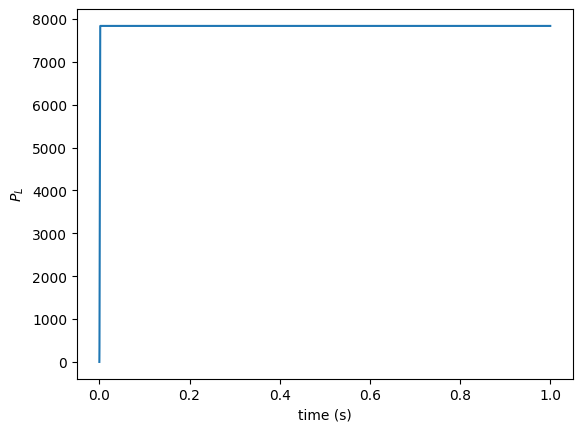

In [4]:
from letalker.constants import PL

gen = lt.Constant(PL, transition_time=0.001)
# the default transition is a 2-ms raised-cosine transition

plt.plot(t, gen(n))
plt.xlabel("time (s)")
plt.ylabel("$P_L$")

## `StepGenerator` - hold specific values in a sequential order

The `transition_time` of `Constant` class only lets you switch the value between the specified value and 0. The `StepGenerator` class generalizes this behavior and let you specify multiple values to hold. The transitions are by default raised-cosines over 2-ms long.


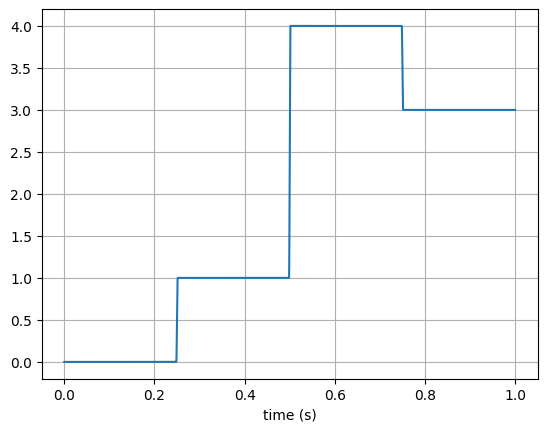

In [5]:
gen = lt.StepGenerator(transition_times=[0.25, 0.5, 0.75], levels=[0, 1, 4, 3])
# note levels has one more item than transition_times
plt.plot(t, gen(lt.fs))
plt.xlabel("time (s)")
plt.grid()

Using this class, we can create a vocal tract area profile which traverses through multiple vowels...


44100
(44100, 44)


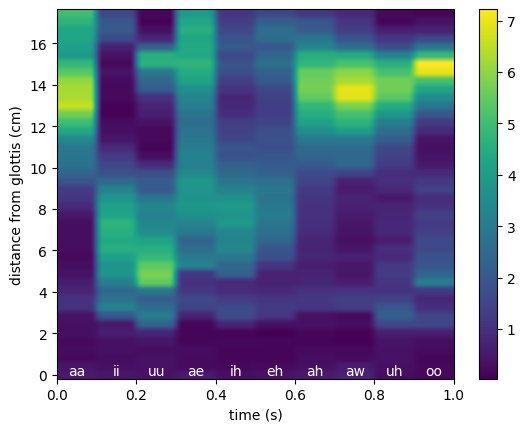

In [6]:
from letalker.constants import (
    vocaltract_areas as areas,
    vocaltract_names as names,
    vocaltract_resolution,
)

names = [vowel for vowel in names[:10]]
areas = np.stack([areas[vowel] for vowel in names], 0)
transition_times = np.arange(1, len(names)) * 0.1

vtarea_fun = lt.StepGenerator(transition_times, areas, transition_time_constant=0.02)
print(vtarea_fun.fs)

area = vtarea_fun(n)
print(area.shape)
plt.imshow(
    area.T,
    extent=[0, 1.0, -0.5 * vocaltract_resolution, 44.5 * vocaltract_resolution],
    origin="lower",
    aspect="auto",
)
for i, name in enumerate(names):
    ti = i * 0.1 + 0.05
    plt.annotate(
        name, (ti, 0.01), xycoords=("data", "axes fraction"), c="w", ha="center"
    )
plt.xlabel("time (s)")
plt.ylabel("distance from glottis (cm)")
plt.colorbar()

## `LineGenerator`

`LineGenerator` creates a steady transition from one level to another. Outside of the two end points may be held to their levels or continue the linear trend indefinitely.


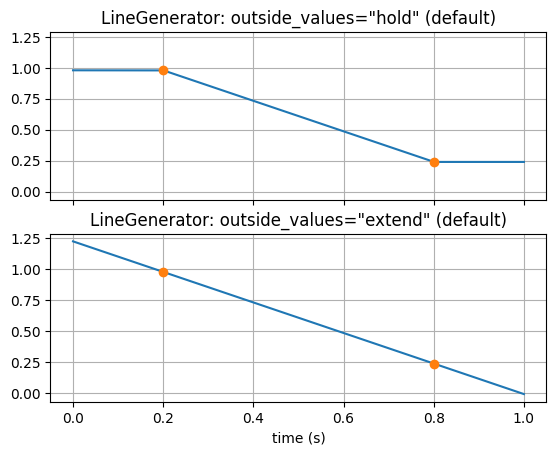

In [7]:
tp = (0.2, 0.8)
xp = (0.98, 0.24)
gen0 = lt.LineGenerator(tp, xp)
gen1 = lt.LineGenerator(tp, xp, outside_values="extend")

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(t, gen0(n))
axes[0].plot(tp, xp, "o")
axes[0].set_title('LineGenerator: outside_values="hold" (default)')
axes[0].grid()
axes[1].plot(t, gen1(n))
axes[1].plot(tp, xp, "o")
axes[1].set_title('LineGenerator: outside_values="extend" (default)')
axes[1].set_xlabel("time (s)")
axes[1].grid()

## Interpolators: `Interpolator`, `ClampedInterpolator`, & `PeriodicInterpolator`

These three `Interpolator` function generator classes perhaps are the most critical to construct time-varying parameters for speech-like voice samples. These generators support multidimensional functions (e.g., vocal tract cross-sectional areas). By default, this class uses B-splines for interpolation, but other polynomial based interpolators are also supported.


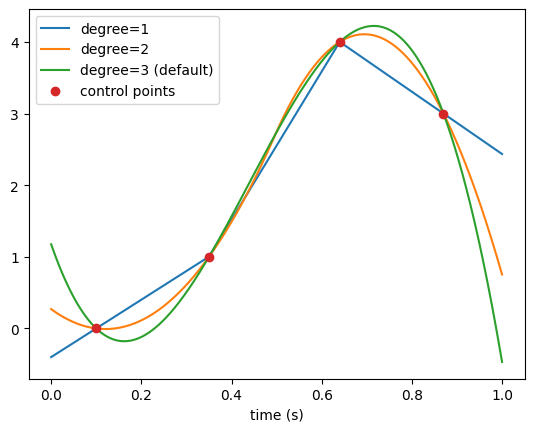

In [8]:
tp = [0.1, 0.35, 0.64, 0.87]
xp = [0, 1, 4, 3]
gen1 = lt.Interpolator(tp, xp, degree=1)
gen2 = lt.Interpolator(tp, xp, degree=2)
gen3 = lt.Interpolator(tp, xp, degree=3)

plt.plot(t, gen1(n), label="degree=1")
plt.plot(t, gen2(n), label="degree=2")
plt.plot(t, gen3(n), label="degree=3 (default)")
plt.plot(tp, xp, "o", label="control points")
plt.xlabel("time (s)")
plt.legend()

Example of multi-dimensional interpolator


Text(0.5, 0, 'time (s)')

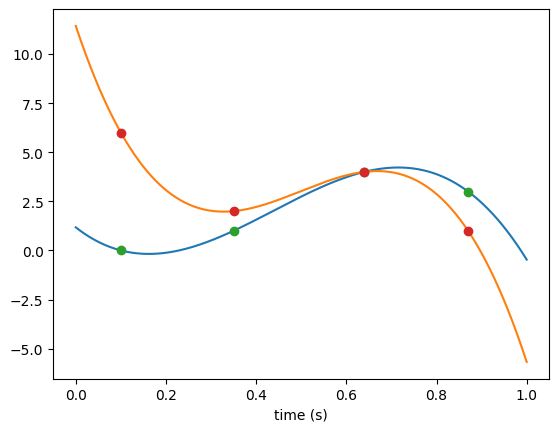

In [9]:
tp = [0.1, 0.35, 0.64, 0.87]
xp = [[0, 6], [1, 2], [4, 4], [3, 1]]
gen = lt.Interpolator(tp, xp)

plt.plot(t, gen(n))
plt.plot(tp, xp, "o")
plt.xlabel("time (s)")

The two sub-flavors of `Interpolator` classes `ClampedInterpolator` and `PeriodicInterpolator`. Here is an example of how these three interpolator classes behave with the same set of control points.


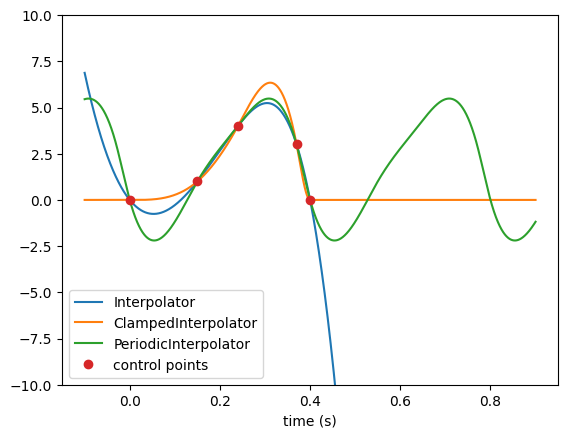

In [10]:
tp = [0, 0.15, 0.24, 0.37, 0.4]
xp = [0, 1, 4, 3, 0]

gen1 = lt.Interpolator(tp, xp)
gen2 = lt.ClampedInterpolator(tp, xp)
gen3 = lt.PeriodicInterpolator(tp, xp)

n0 = round(-0.1 * lt.fs)
t1 = lt.ts(n, n0)

plt.plot(t1, gen1(n, n0), label="Interpolator")
plt.plot(t1, gen2(n, n0), label="ClampedInterpolator")
plt.plot(t1, gen3(n, n0), label="PeriodicInterpolator")
plt.plot(tp, xp, "o", label="control points")
plt.xlabel("time (s)")
plt.ylim(-10, 10)
plt.legend()

Note `PeriodicInterpolator` is also a subclass of `AnalyticFunctionGenerator` but its analytic signal generation is approximate, relying on `scipy.signal.hilbert()`.


## `FlutterGenerator` - slow quasi-random drift

Flutter is an $f_o$ effect introduced by Klatt and Klatt (1990) to simulate jitter in voice. This technique (a sum of slow unrelated sinusoids to produce drift) is also useful to perturb any synthesis parameter. The original formulation is an equal sum of 3 sinusoids with carefully picked frequencies, multiplied by a common gain (FL/100*fo/100). In pyLeTalker package, `FlutterGenerator` class is a generalized version, in which the number of sinusoids and frequencies can be modified, and the frequencies can be selected randomly.

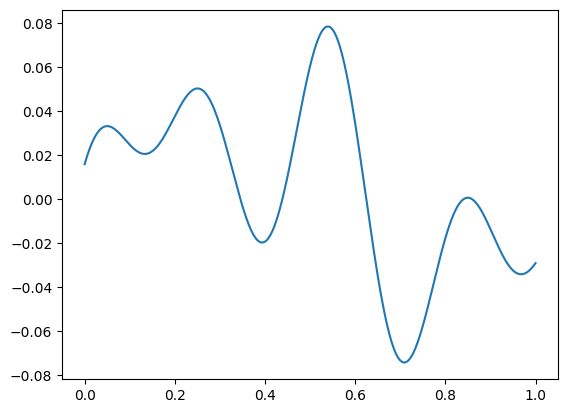

In [11]:
gen1 = lt.FlutterGenerator(0.1, 4, 3)  # default bias = 0.0
plt.plot(t, gen1(lt.fs))

## `SineGenerator`

This class is the key to define the kinematic vocal folds' motion.


Text(0.5, 0, 'time (s)')

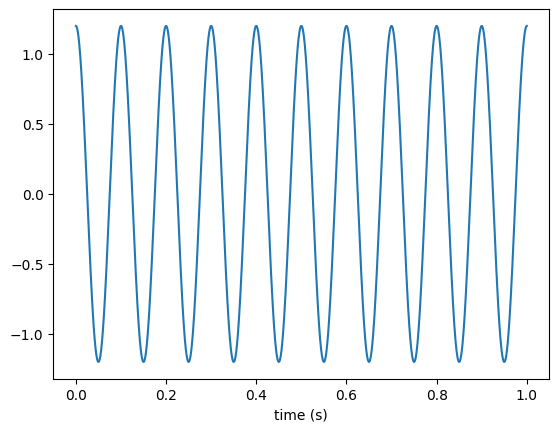

In [12]:
gen = lt.SineGenerator(fo=10, A=1.2, phi0=np.pi / 2)
plt.plot(t, gen(n))
plt.xlabel("time (s)")

Any function generator could be used for `A` parameter:


Text(0.5, 0, 'time (s)')

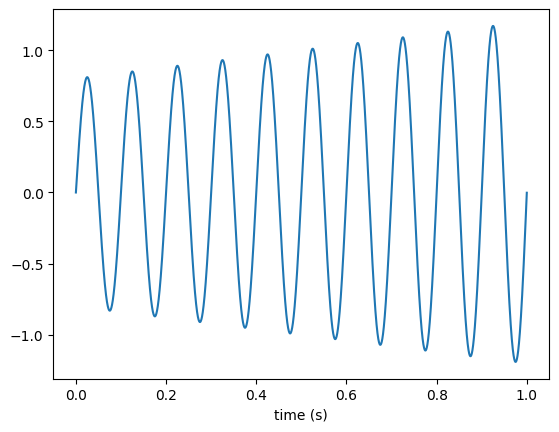

In [13]:
# time-varyinng amplitude
Atv = lt.LineGenerator((0, 1), (0.8, 1.2))
gen = lt.SineGenerator(fo=10, A=Atv)
plt.plot(t, gen(n))
plt.xlabel("time (s)")

... and `fo` parameter. The following example shows the spectrograms of the generated time-varying sinusoid overlayed with the time-varying fo parameter (in red).


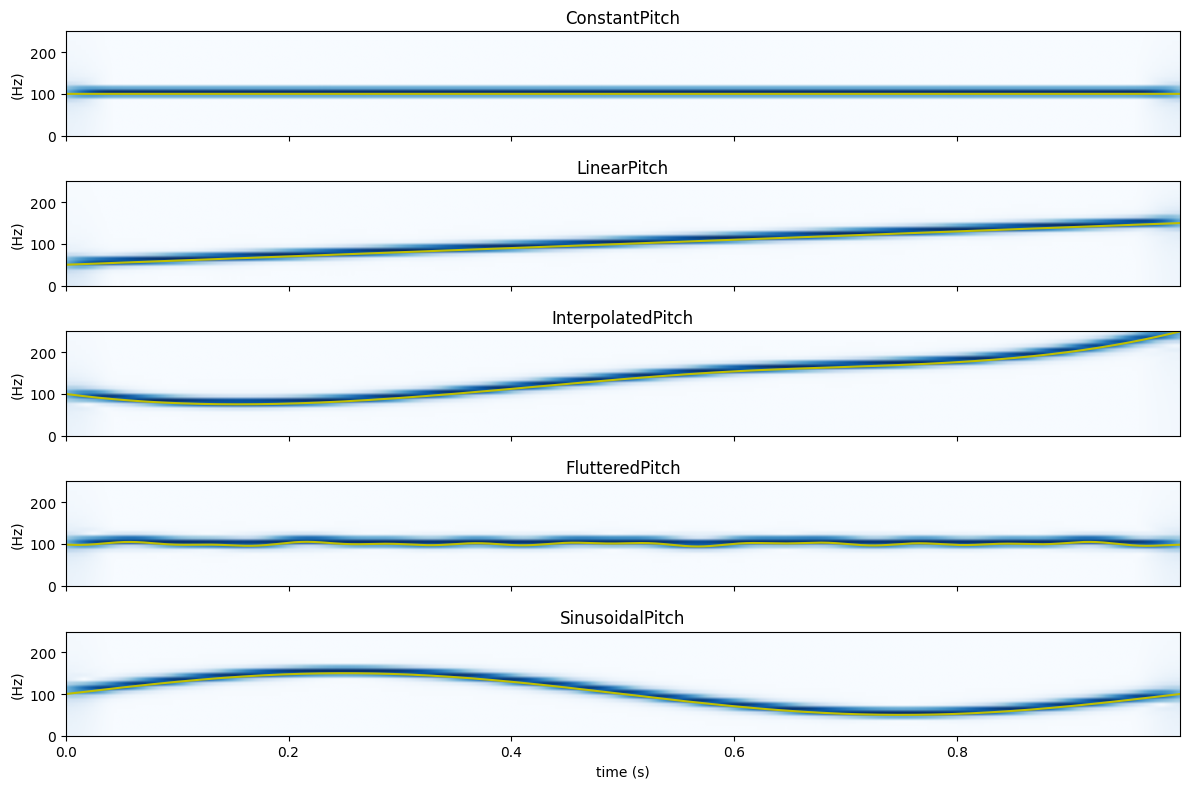

In [14]:
fo_objs = {
    "ConstantPitch": lt.Constant(100),
    "LinearPitch": lt.LineGenerator([0, 1], [50, 150]),
    "InterpolatedPitch": lt.Interpolator(
        [0, 0.3, 0.6, 0.9, 1.0], [100, 90.4, 154.2, 200.6, 250]
    ),
    "FlutteredPitch": lt.FlutterGenerator(100 / 50 * 100 / 100 * 3, bias=100),
    "SinusoidalPitch": lt.SineGenerator(1, 50, bias=100),
}


from scipy.signal import ShortTimeFFT, get_window
from scipy.fft import next_fast_len
from scipy.signal.windows import gaussian

g_std = 8  # standard deviation for Gaussian window in samples

N = lt.fs // 10
w = gaussian(N, std=g_std, sym=True)  # symmetric Gaussian window
w = get_window("hann", N)
SFT = ShortTimeFFT(w, hop=round(N * 0.01), fs=lt.fs, mfft=next_fast_len(N), scale_to="psd")


fig, axes = plt.subplots(len(fo_objs), 1, sharex=True, sharey=True, figsize=[12, 8])
for (name, fo), ax in zip(fo_objs.items(), axes):
    gen = lt.SineGenerator(fo=fo)
    t = fo.ts(n)
    fo_vals = fo(n, force_time_axis='tile_data')
    Sx = SFT.stft(gen(n))  # perform the STFT
    im1 = ax.imshow(
        abs(Sx), origin="lower", aspect="auto", extent=SFT.extent(n), cmap="Blues"
    )
    ax.plot(t, fo_vals, "y")
    ax.set_title(name)
    ax.set_ylabel("(Hz)")
axes[0].set_ylim([0, 250])
axes[0].set_xlim([0, t[-1]])
axes[-1].set_xlabel("time (s)")
fig.tight_layout()

Text(0.5, 0, 'time (s)')

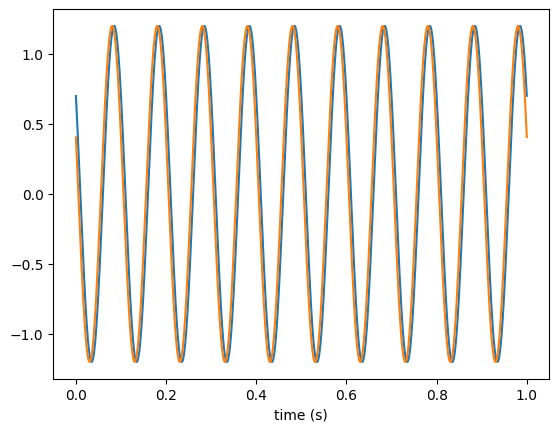

In [15]:
# gen = lt.SineGenerator(fo=[10,11], A=1.2, phi0=np.pi / 2)
gen = lt.SineGenerator(fo=[10,10], A=1.2, phi0='random')
plt.plot(t, gen(n))
plt.xlabel("time (s)")

## `ModulatedSineGenerator`

To simulate amplitude and frequency modulated vocal fold vibration using the kinematic model, `ModulatedSineGenerator` could be used to generate the reference motion.


(0.0, 1000.0)

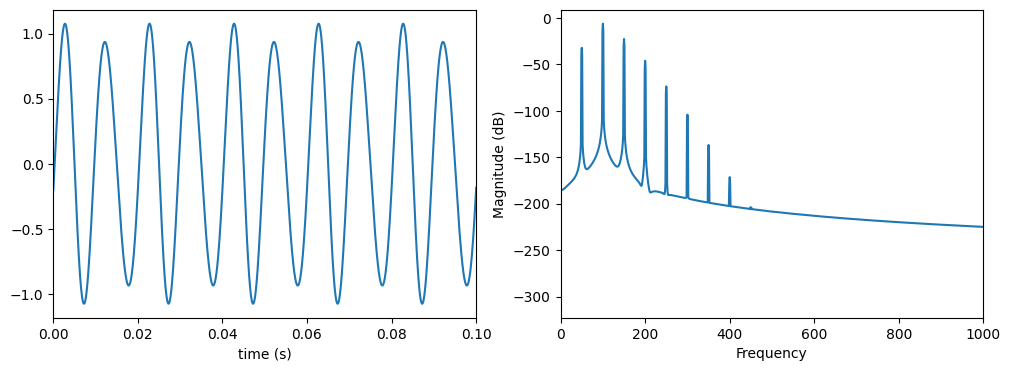

In [16]:
fo = 100
modulation_frequency = 0.5  # relative to fo
am_extent = 0.1  # amount of amplitude modulation
fm_extent = 0.1  # amount of frequency modulation
gen = lt.ModulatedSineGenerator(fo, modulation_frequency, am_extent, fm_extent)
x = gen(n)

fig, axes = plt.subplots(1, 2, figsize=[12, 4])
axes[0].plot(t, x)
axes[0].set_xlabel("time (s)")
axes[0].set_xlim([0, 0.1])
axes[1].magnitude_spectrum(x, Fs=gen.fs, scale="dB", window=np.hamming(len(t)))
axes[1].set_xlim([0, min(1000, lt.fs / 2)])

## `WhiteNoiseGenerator` & `ColoredNoiseGenerator`

To simulate turbulent/aspiration/ambient noise, these generators produce random noise samples with a specified power level.


0.09995925487893695


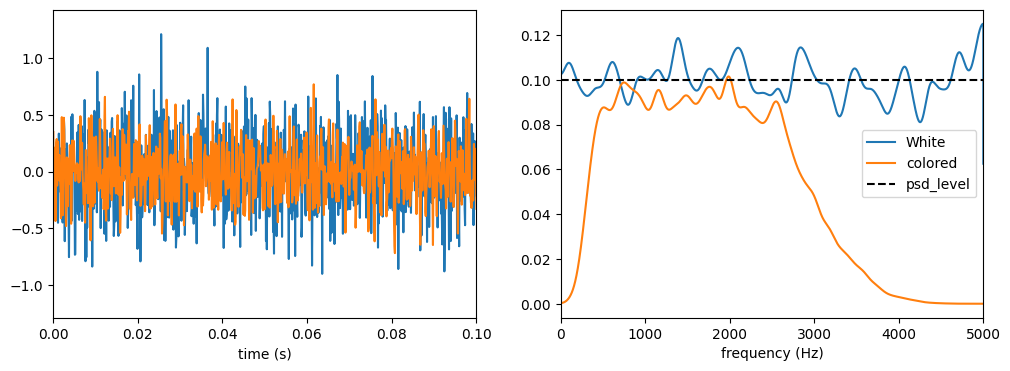

In [17]:
from scipy.signal import welch

lt.core.set_sampling_rate(10000)

pi = np.pi

b = [1.25]
a = [1, -0.75]

psd_level=0.1

gen0 = lt.WhiteNoiseGenerator(0.1)
# gen1 = ColoredNoiseGenerator(
#     LeTalkerAspirationNoise.cb, LeTalkerAspirationNoise.ca, psd_level=psd_level
# )
gen1 = lt.ColoredNoiseGenerator(2, (300, 3000), "bandpass", psd_level=psd_level)
fs = n = gen0.fs
t = gen0.ts(n)
x = gen0(n)
y = gen1(n)
print(np.var(x))

n = fs // 100
f, Pxx = welch(
    x, fs, "hann", n, n // 2, nfft=1024 * 16, scaling="density", detrend=False
)
f, Pyy = welch(
    y, fs, "hann", n, n // 2, nfft=1024 * 16, scaling="density", detrend=False
)

fig, axes = plt.subplots(1, 2, figsize=[12, 4])

axes[0].plot(t, x)
axes[0].plot(t, y)
axes[0].set_xlabel("time (s)")
axes[0].set_xlim([0, 0.1])
axes[1].plot(f, Pxx * fs / 2, label='White')
axes[1].plot(f, Pyy * fs / 2, label='colored')
axes[1].axhline(psd_level,ls='--',c='k',label='psd_level')
axes[1].set_xlim([0, min(fs / 2, 10000)])
axes[1].set_xlabel("frequency (Hz)")
axes[1].legend();